In [1]:
!nvidia-smi

Fri Aug 18 11:22:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -q numpy
!pip install -q matplotlib
!pip install -q pandas
!pip install -q tensorflow
!pip install -q scikit-learn
!pip install -q pandas-datareader
!pip install -q yfinance
!pip install --upgrade mplfinance

In [3]:
import os
import sys
from google.colab import drive
drive.mount('/content/drive/')

# Set the working directory for the tasks
SKELETON_DIR = '/content/drive/MyDrive/stock-prediction/V1'
os.chdir(SKELETON_DIR)

Mounted at /content/drive/


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
import tensorflow as tf
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, InputLayer

In [6]:
# Load Data
DATA_SOURCE = "yahoo"
COMPANY = "TSLA"

# start = '2012-01-01', end='2017-01-01'
TRAIN_START = '2016-01-01'
TRAIN_END = '2023-08-16'

if not os.path.isdir("data"):
    os.mkdir("data")

DATA_DIR = "/content/drive/MyDrive/stock-prediction/V1/data"
CSV_FILE = os.path.join(DATA_DIR, f"{COMPANY}_stock_data.csv")

# Check if CSV file exists
if os.path.exists(CSV_FILE):
    # Load data from CSV
    data = pd.read_csv(CSV_FILE)
else:
    # Fetch data from Yahoo Finance
    data = yf.download(COMPANY, start=TRAIN_START, end=TRAIN_END, progress=False)
    # Save data to CSV
    data.to_csv(CSV_FILE)

# Display the first few rows of the data
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,15.381333,15.425333,14.600000,14.894000,14.894000,102406500
2016-01-05,15.090667,15.126000,14.666667,14.895333,14.895333,47802000
2016-01-06,14.666667,14.670000,14.398667,14.602667,14.602667,56686500
2016-01-07,14.279333,14.562667,14.244667,14.376667,14.376667,53314500
2016-01-08,14.524000,14.696000,14.051333,14.066667,14.066667,54421500


In [7]:
# Prepare Data
# Check if data has been prepared before
PREPARED_DATA_FILE = os.path.join(DATA_DIR, f"{COMPANY}_prepared_data.npz")

# Number of days to look back to base the prediction
PREDICTION_DAYS = 60 # Can be changed if needed

if os.path.exists(PREPARED_DATA_FILE):
    # Load the prepared data
    loaded_data = np.load(PREPARED_DATA_FILE)
    x_train = loaded_data['x_train']
    y_train = loaded_data['y_train']
else:
    # Use a mid-point of Open & Close as the price value
    # data['Mid'] = (data['Open'] + data['Close']) / 2
    PRICE_VALUE = "Close" #"Mid"

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[PRICE_VALUE].values.reshape(-1, 1))
    scaled_data = scaled_data[:,0]

    x_train = []
    y_train = []

    for x in range(PREDICTION_DAYS, len(scaled_data)):
        x_train.append(scaled_data[x-PREDICTION_DAYS:x])
        y_train.append(scaled_data[x])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # Save the prepared data
    np.savez(PREPARED_DATA_FILE, x_train=x_train, y_train=y_train)

In [8]:
# Build the Model
MODEL_FILE = os.path.join(DATA_DIR, f"{COMPANY}_trained_model.h5")

# Check if model has been built before
if os.path.exists(MODEL_FILE):
    # Load the pre-trained model
    model = tf.keras.models.load_model(MODEL_FILE)
else:
    model = Sequential()

    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(x_train, y_train, epochs=100, batch_size=32)

    # Save the trained model
    model.save(MODEL_FILE)


Epoch 1/100
59/59 [==============================] - 13s 16ms/step - loss: 0.0091
Epoch 2/100
59/59 [==============================] - 1s 12ms/step - loss: 0.0036
Epoch 3/100
59/59 [==============================] - 1s 11ms/step - loss: 0.0032
Epoch 4/100
59/59 [==============================] - 1s 12ms/step - loss: 0.0032
Epoch 5/100
59/59 [==============================] - 1s 12ms/step - loss: 0.0026
Epoch 6/100
59/59 [==============================] - 1s 12ms/step - loss: 0.0025
Epoch 7/100
59/59 [==============================] - 1s 13ms/step - loss: 0.0028
Epoch 8/100
59/59 [==============================] - 1s 12ms/step - loss: 0.0025
Epoch 9/100
59/59 [==============================] - 1s 12ms/step - loss: 0.0022
Epoch 10/100
59/59 [==============================] - 1s 12ms/step - loss: 0.0025
Epoch 11/100
59/59 [==============================] - 1s 12ms/step - loss: 0.0022
Epoch 12/100
59/59 [==============================] - 1s 12ms/step - loss: 0.0020
Epoch 13/100
59/59 [====

In [9]:
# Test the model accuracy on existing data
# Load the test data
TEST_START = '2015-01-01'
TEST_END = '2023-08-16'
test_data = yf.download(COMPANY, start=TRAIN_START, end=TRAIN_END, progress=False)
# test_data['Mid'] = (test_data['Open'] + test_data['Close']) / 2

actual_prices = test_data[PRICE_VALUE].values
total_dataset = pd.concat((data[PRICE_VALUE], test_data[PRICE_VALUE]), axis=0)

# Preparing inputs for the model. The reshaping is done to convert the 1D array
# into a 2D array where each row is a data point.
model_inputs = total_dataset[len(total_dataset) - len(test_data) - PREDICTION_DAYS:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

# Clipping the scaled values to ensure they are within [0, 1] range
model_inputs = np.clip(model_inputs, 0, 1)

In [10]:
# Preparing the test dataset. Each entry in x_test is a sequence of previous
# PREDICTION_DAYS data points and is used to predict the next point.
x_test = [model_inputs[x - PREDICTION_DAYS:x, 0] for x in range(PREDICTION_DAYS, len(model_inputs))]
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

60/60 [==============================] - 2s 7ms/step


/usr/local/lib/python3.10/dist-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


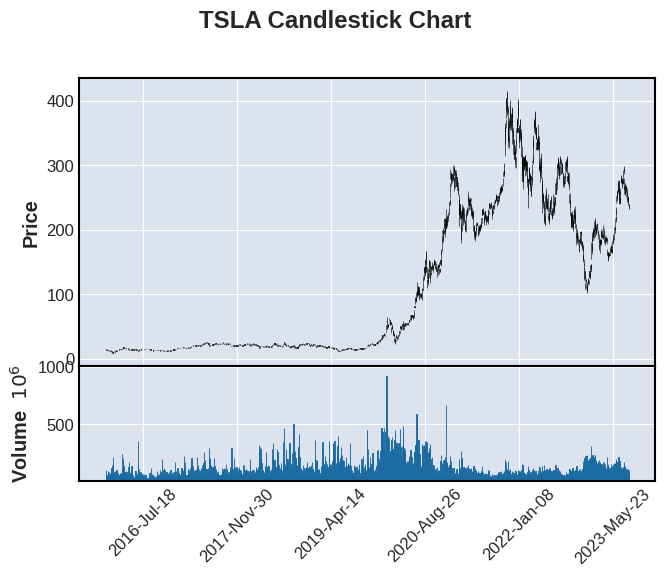

In [11]:
import mplfinance as mpf

# Candlestick chart
mpf.plot(test_data, type='candle', title=f'{COMPANY} Candlestick Chart', volume=True, show_nontrading=True)

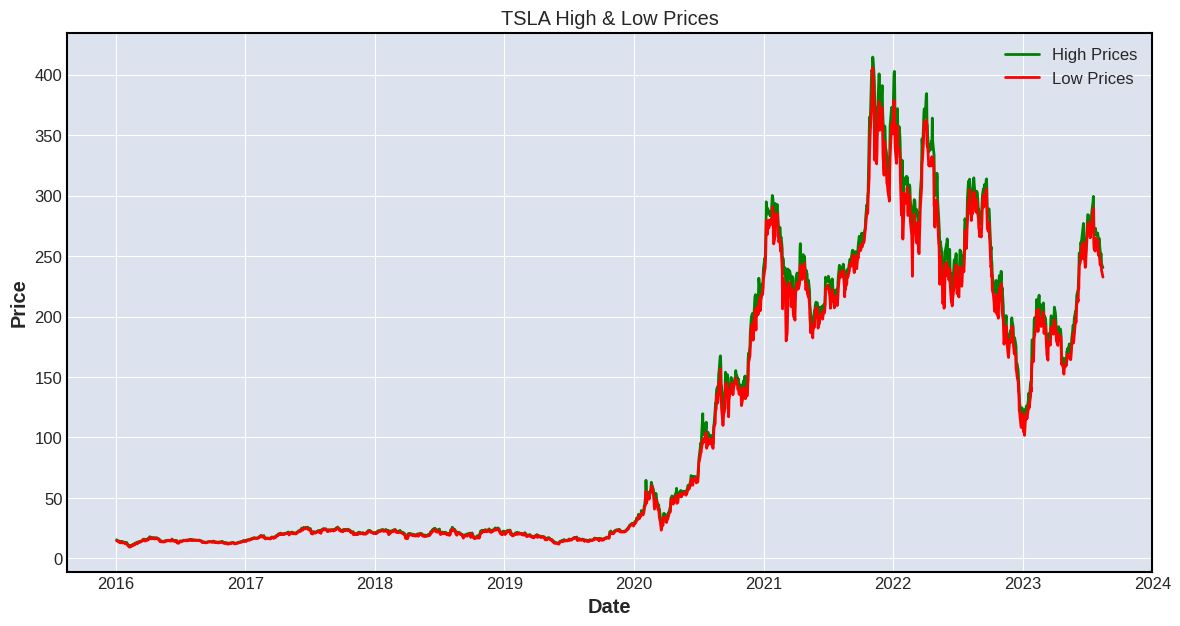

In [12]:
plt.figure(figsize=(14,7))
plt.plot(test_data.index, test_data['High'], color='green', label='High Prices')
plt.plot(test_data.index, test_data['Low'], color='red', label='Low Prices')
plt.title(f'{COMPANY} High & Low Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

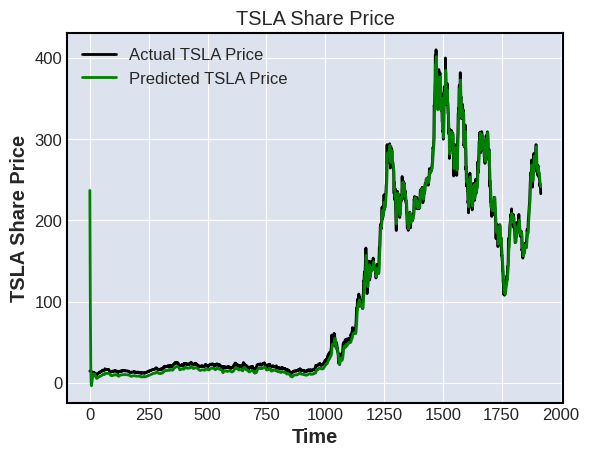

In [13]:
# Plot Test Prediction
plt.plot(actual_prices, color="black", label=f"Actual {COMPANY} Price")
plt.plot(predicted_prices, color="green", label=f"Predicted {COMPANY} Price")
plt.title(f"{COMPANY} Share Price")
plt.xlabel("Time")
plt.ylabel(f"{COMPANY} Share Price")
plt.legend()
plt.show()

In [14]:
# Price next day
real_data = [model_inputs[len(model_inputs) - PREDICTION_DAYS:, 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction: {prediction}")

1/1 [==============================] - 0s 22ms/step
Prediction: [[236.9886]]


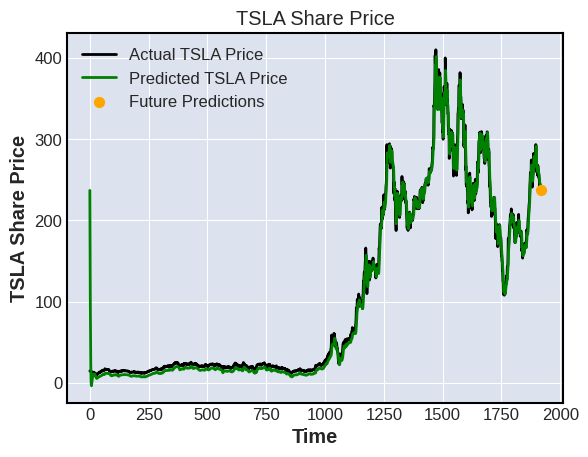

In [15]:
# Plot Test Prediction
plt.plot(actual_prices, color="black", label=f"Actual {COMPANY} Price")
plt.plot(predicted_prices, color="green", label=f"Predicted {COMPANY} Price")

# Extend the x-axis for future predictions
future_x = len(actual_prices)  # The next day's index

plt.scatter(future_x, prediction.flatten(), color='orange', label='Future Predictions', s=50, zorder=5)  # Using scatter to highlight the single point

plt.title(f"{COMPANY} Share Price")
plt.xlabel("Time")
plt.ylabel(f"{COMPANY} Share Price")
plt.legend()
plt.show()

[*********************100%%**********************]  1 of 1 completed
1/1 [==============================] - 0s 139ms/step
Date: 2023-08-17, Predicted Price: 230.64585876464844
1/1 [==============================] - 0s 65ms/step
Date: 2023-08-18, Predicted Price: 229.2869415283203
1/1 [==============================] - 0s 122ms/step
Date: 2023-08-19, Predicted Price: 229.15982055664062
1/1 [==============================] - 0s 83ms/step
Date: 2023-08-20, Predicted Price: 229.14120483398438
1/1 [==============================] - 0s 182ms/step
Date: 2023-08-21, Predicted Price: 229.05735778808594
1/1 [==============================] - 0s 184ms/step
Date: 2023-08-22, Predicted Price: 228.95957946777344
1/1 [==============================] - 0s 151ms/step
Date: 2023-08-23, Predicted Price: 228.90367126464844
1/1 [==============================] - 0s 40ms/step
Date: 2023-08-24, Predicted Price: 228.91392517089844
1/1 [==============================] - 0s 38ms/step
Date: 2023-08-25, Predicted

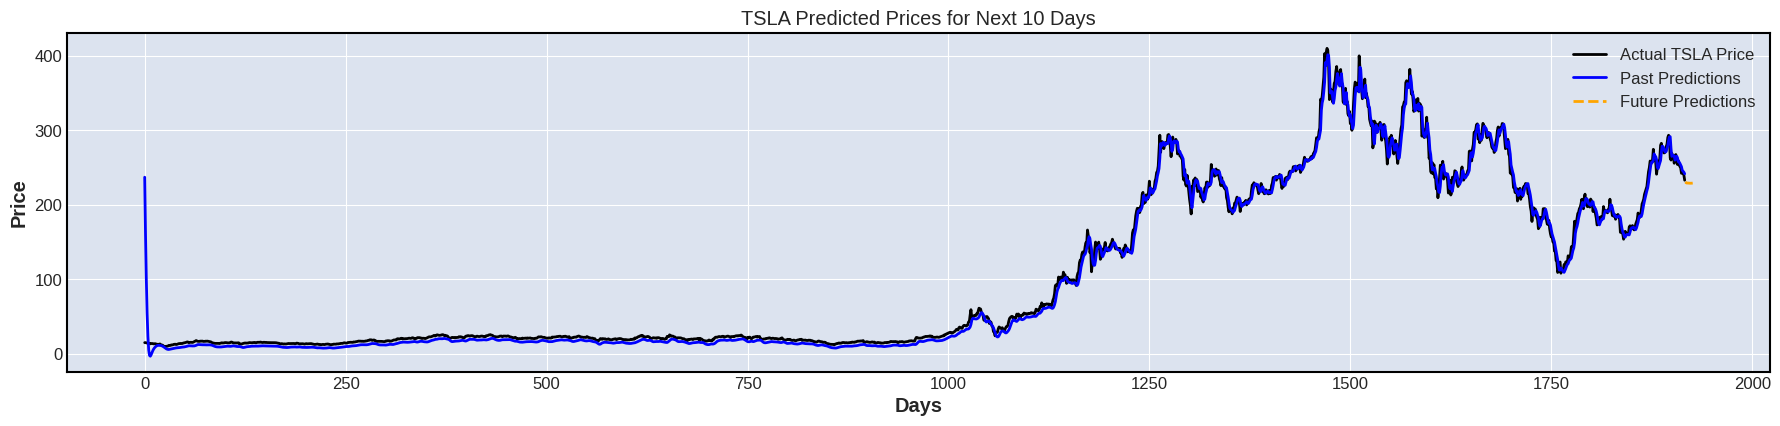

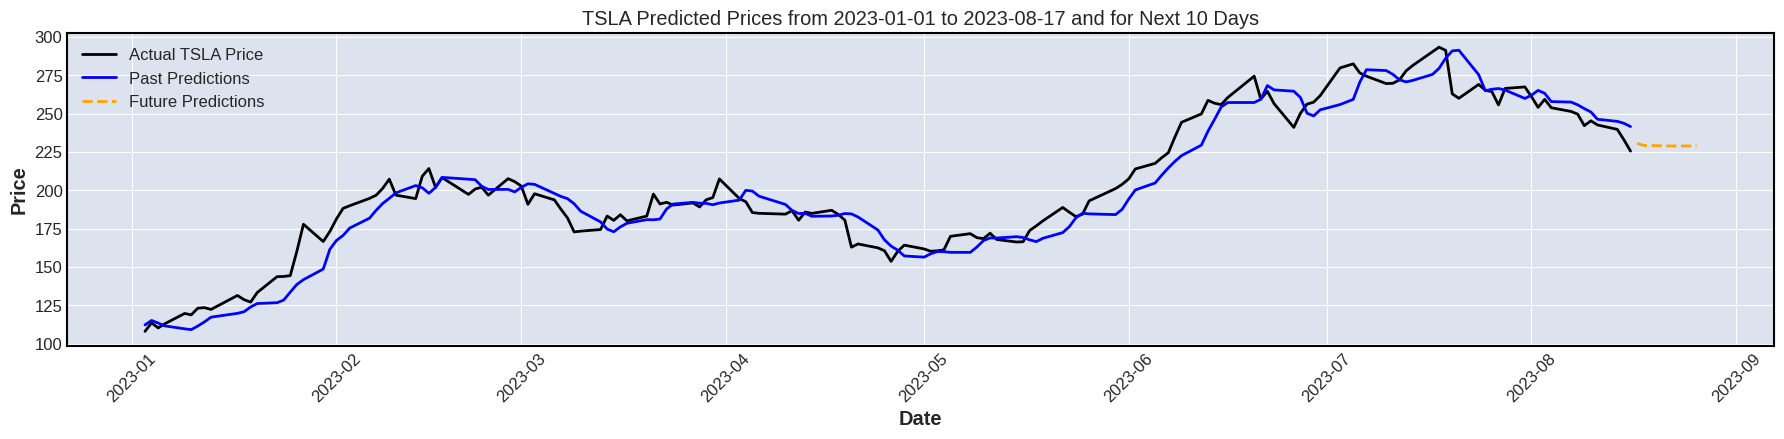

In [18]:
from datetime import timedelta

# Define the list of companies
companies = ["TSLA"]

# Placeholder for future predictions of each company
future_days = 10
future_predictions = {}

TEST_START = '2023-01-01'
TEST_END = '2023-08-17'

# Iterate over each company to make predictions
for COMPANY in companies:
    # Download the most recent data
    latest_data = yf.download(COMPANY, start=TEST_START, end=TEST_END, progress=True)
    actual_latest_prices = latest_data["Close"].values

    # Get the date values
    latest_dates = latest_data.index.to_list()

    # Generate future dates based on the last date in latest_dates
    last_known_date = latest_dates[-1]
    future_dates = [last_known_date + timedelta(days=i) for i in range(1, future_days + 1)]

    # Prepare the data
    total_dataset = pd.concat((data["Close"], latest_data["Close"]), axis=0)
    model_inputs = total_dataset[-(PREDICTION_DAYS + future_days):].values
    model_inputs = model_inputs.reshape(-1, 1)
    model_inputs = scaler.transform(model_inputs)

    # Use the trained model to make predictions
    predictions_future = []
    current_batch = model_inputs[-PREDICTION_DAYS:]
    current_batch = current_batch.reshape((1, PREDICTION_DAYS, 1))

    for i in range(future_days):
        current_date = future_dates[i]
        predicted_value = model.predict(current_batch)[0]
        predictions_future.append(predicted_value)
        current_batch = np.append(current_batch[:,1:,:], [[predicted_value]], axis=1)
        predicted_price = scaler.inverse_transform(predicted_value.reshape(-1, 1))[0,0]
        print(f"Date: {current_date.strftime('%Y-%m-%d')}, Predicted Price: {predicted_price:}")



    # Inverse transform the future predictions
    predicted_prices_future = scaler.inverse_transform(predictions_future)

    # Store the predictions
    future_predictions[COMPANY] = predicted_prices_future

# Plotting the actual prices, past predictions, and future predictions for each company
plt.figure(figsize=(18, 12))
for idx, COMPANY in enumerate(companies, 1):
    plt.subplot(3, 1, idx)

    # Plotting the actual prices
    plt.plot(actual_prices, color='black', label=f"Actual {COMPANY} Price")

    # Plotting the past predictions
    plt.plot(predicted_prices, color='blue', label=f"Past Predictions")

    # Plotting the future predictions
    future_dates_range = np.arange(len(predicted_prices), len(predicted_prices) + future_days)
    plt.plot(future_dates_range, future_predictions[COMPANY], color='orange', linestyle='dashed', label='Future Predictions')

    plt.title(f"{COMPANY} Predicted Prices for Next {future_days} Days")
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# Plotting the actual prices, past predictions, and future predictions for each company
plt.figure(figsize=(18, 12))
for idx, COMPANY in enumerate(companies, 1):
    plt.subplot(3, 1, idx)

    # Create a combined list of dates from TEST_START to TEST_END and the future dates
    combined_dates = latest_dates + future_dates[:future_days]

    # Plotting the actual prices from TEST_START to TEST_END
    plt.plot(combined_dates[:len(latest_dates)], actual_latest_prices, color='black', label=f"Actual {COMPANY} Price")

    # Plotting the past predictions from TEST_START to TEST_END
    plt.plot(latest_dates, predicted_prices[-len(latest_dates):], color='blue', label=f"Past Predictions")

    # Plotting the future predictions
    plt.plot(combined_dates[len(latest_dates):], future_predictions[COMPANY], color='orange', linestyle='dashed', label='Future Predictions')

    plt.title(f"{COMPANY} Predicted Prices from {TEST_START} to {TEST_END} and for Next {future_days} Days")
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()